In [50]:
import os,sys
import glob
from shutil import unpack_archive

unpack_archive('vehicles.zip')
basedir= 'vehicles/vehicles/'
image_types = os.listdir(basedir)
cars=[]
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))
print ('Number of vehicle:', len(cars))
with open ("cars.txt",'w') as f:
    for fn in cars:
        f.write(fn+'\n')
unpack_archive('non-vehicles.zip')
basedir= 'non-vehicles/non-vehicles/'

image_types = os.listdir(basedir)
noncars=[]
for imtype in image_types:
    noncars.extend(glob.glob(basedir+imtype+'/*'))
print ('Number of non-vehicles:', len(noncars))
with open ("noncars.txt",'w') as f:
    for fn in noncars:
        f.write(fn+'\n')

Number of vehicle: 8792
Number of non-vehicles: 8968


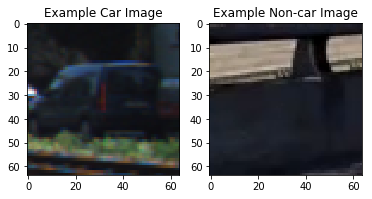

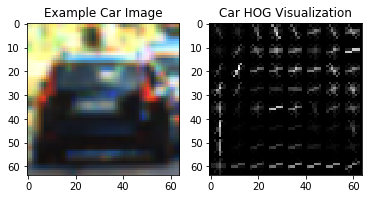

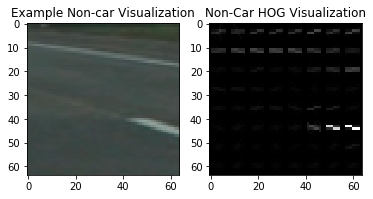

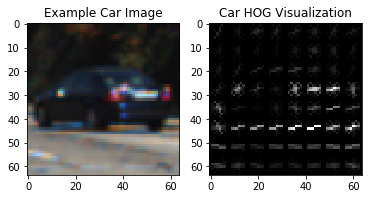

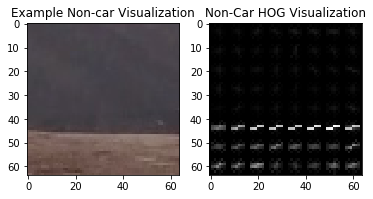

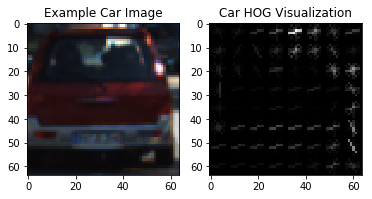

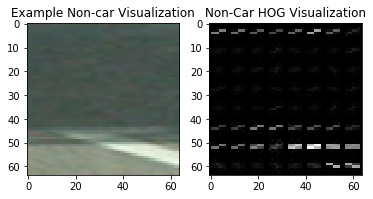

In [98]:
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Function to Return Car and Not-car Images
def plot_car(cars, noncars):
    
    # Just for fun choose random car / not-car indices and plot example images   
    car_ind = np.random.randint(0, len(cars))
    noncar_ind = np.random.randint(0, len(noncars))

    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    noncar_image = mpimg.imread(noncars[noncar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(noncar_image)
    plt.title('Example Non-car Image')
    
#Function to plot Hog images of Cars/Non-Cars    
def plot_hog(cars, noncars):    
    #cars, notcars = read_dataset()
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL"
    
    for x in range(0,3):
    
        # Generate a random index to look at a car image
        ind = np.random.randint(0, len(cars))
        # Read in the image
        image_car = mpimg.imread(cars[ind])
        gray_car = cv2.cvtColor(image_car, cv2.COLOR_RGB2GRAY)
        
        image_noncar = mpimg.imread(noncars[ind])
        gray_noncar = cv2.cvtColor(image_noncar, cv2.COLOR_RGB2GRAY)
        
        # Call our function with vis=True to see an image output
        features_car, hog_image_car = get_hog_features(gray_car, orient, 
                                pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=False)
        
        features_notcar, hog_image_noncar = get_hog_features(gray_noncar, orient, 
                                pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=False)
        
        # Plot the examples
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(image_car, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(hog_image_car, cmap='gray')
        plt.title('Car HOG Visualization')
        
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(image_noncar, cmap='gray')
        plt.title('Example Non-car Visualization')
        plt.subplot(122)
        plt.imshow(hog_image_noncar, cmap='gray')
        plt.title('Non-Car HOG Visualization')        
        x = x+1


plot_car(cars,noncars)    
plot_hog(cars,noncars)

In [128]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Function to compute Spatial Bins
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Function to compute color histogram features  
def color_hist(img, nbins=32): # bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Function to extract all features  
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Function to convert Image color
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
# Here I define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Here is the draw_boxes function 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
                hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

def visualize (fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            

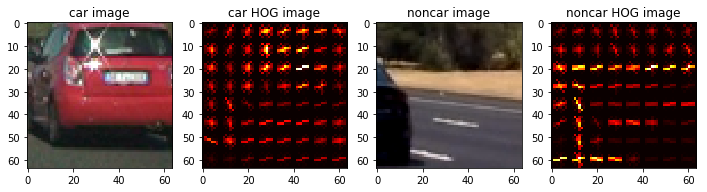

In [129]:
%matplotlib inline

car_ind = np.random.randint(0, len(cars))
noncar_ind = np.random.randint(0, len(noncars))
# Read in the image
image_car = mpimg.imread(cars[car_ind])
image_noncar = mpimg.imread(noncars[noncar_ind])        
        
cs= 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # can be "ALL" , 0, 1, 2
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [None, None] # Min and max in y to search in slide_window()
    
car_features, car_hog_image = single_img_features(image_car, color_space=cs, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
noncar_features, noncar_hog_image = single_img_features(image_noncar, color_space=cs, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
images = [image_car, car_hog_image, image_noncar, noncar_hog_image]
titles = ['car image', 'car HOG image', 'noncar image', 'noncar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)
    


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
35.64 Seconds to train SVC...
Test Accuracy of SVC =  0.9925
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  1.  1.  1.]
0.01142 Seconds to predict 10 labels with SVC


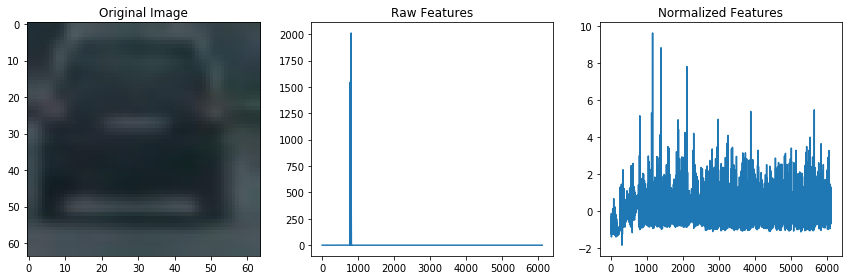

In [79]:
def train(cars, noncars):    
    # Here are the Parameters used in the project
    color_space= 'YCrCb' # or  RGB, HSV, LUV, HLS, YUV
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # can be "ALL" , 0, 1, 2
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16   # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()
    car_features=[]
    t=time.time()
    t2 = time.time()
    n_samples = 2000
    random_indx = np.random.randint(0, len(cars), n_samples)
    test_cars = np.array(cars)[random_indx]
    test_noncars = np.array(noncars)[random_indx]
    
    car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    noncar_features = extract_features(test_noncars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
#print (t2-t, 'Secs to compute....')  
    
    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        car_ind = np.random.randint(0, len(cars))
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(cars[car_ind]))
        plt.title('Original Image')
        plt.subplot(132)
        plt.plot(X[car_ind])
        plt.title('Raw Features')
        plt.subplot(133)
        plt.plot(scaled_X[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
    else: 
        print('Empty feature vectors...')
    
    # Preparing Labels, and split for Training and Test data
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.1, random_state=rand_state)
    print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')  
    
    return svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins


svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins = train(cars, noncars)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


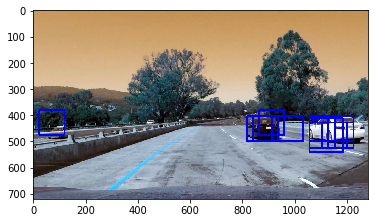

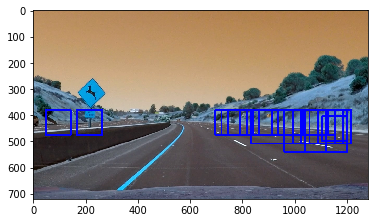

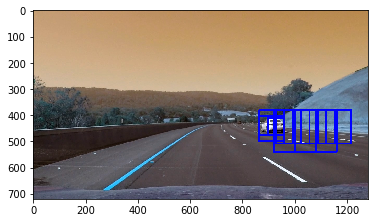

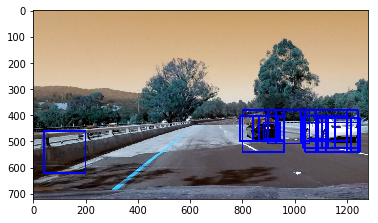

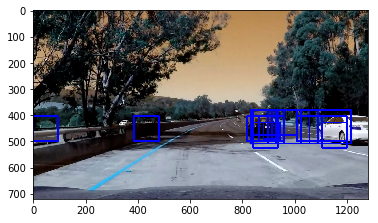

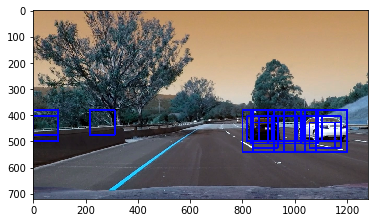

In [80]:
# Function to identify Car in Image, and return list of boxes    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bbox_list

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


test_imgs = glob.glob("test_images/*.jpg")
ystart = 400
ystop = 656
scale = 1.5

for fname in test_imgs:
    bbox_list = []
    img = cv2.imread(fname)
    bbox_list.append(find_cars(img, 380, 510, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    bbox_list.append(find_cars(img, 380, 570, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    bbox_list.append(find_cars(img, 380, 630, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    bbox_list.append(find_cars(img, 380, 690, 2.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))    
    
    #Need to flatten list of lists - http://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
    bbox_list = [item for sublist in bbox_list for item in sublist]   
    box_img = draw_boxes(img, bbox_list,color=(0, 0, 255), thick=6)
    fig = plt.figure()
    plt.imshow(box_img)

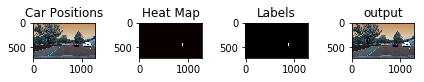

In [94]:
#### from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    # Return updated heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

img = cv2.imread('./test_images/test5.jpg')
heat = np.zeros_like(img[:,:,0]).astype(np.float)
box_list = []
box_list.append(find_cars(img, 390, 510, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
box_list.append(find_cars(img, 390, 570, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
box_list.append(find_cars(img, 390, 630, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
box_list.append(find_cars(img, 390, 690, 2.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))    
box_list = [item for sublist in box_list for item in sublist] 
heat = add_heat(heat,box_list)
heat = apply_threshold(heat,5)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)


plt.show()

fig = plt.figure()
plt.subplot(141)
plt.imshow(img)
plt.title('Car Positions')
plt.subplot(142)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.subplot(143)
plt.imshow(labels[0], cmap='gray')
plt.title('Labels')
fig.tight_layout()
plt.subplot(144)
plt.imshow(draw_img)
plt.title('output')
fig.tight_layout()

In [95]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process(img):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_list = []
    box_list.append(find_cars(img, 380, 500, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    box_list.append(find_cars(img, 380, 570, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))    
    box_list.append(find_cars(img, 380, 630, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    box_list.append(find_cars(img, 380, 700, 2.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))    
    box_list = [item for sublist in box_list for item in sublist] 
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img   

yellow_output = 'Project_out.mp4'
clip2 = VideoFileClip('project_video.mp4', audio=False)
yellow_clip = clip2.fl_image(process)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video Project_out.mp4
[MoviePy] Writing video Project_out.mp4



100%|█████████▉| 1260/1261 [29:41<00:01,  1.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_out.mp4 

CPU times: user 29min 21s, sys: 3.98 s, total: 29min 25s
Wall time: 29min 44s
